# Goal
Load in all the csvs from the Fig3-Fig4 and Fig 4 imagefolders

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from os.path import join
from facet_ml.classification.data_manipulation import create_formatted_df


In [136]:
## Load in the csvs from each folder

# Folder: 
F34_folder = Path("..") / "Results" / "Fig3_Fig4_oven_pcr_linkerstrength_segment_anything"
F4_folder  = Path("..") / "Results" / "Fig4_slow_cooling_rates_segment_anything"

# Load all csvs
F34_csvs = glob.glob( join(str( F34_folder ),"*","*total*.csv" ))
F4_csvs = glob.glob( join(str( F4_folder ),"*","*total*.csv" ))

# Make them into legible dataframes
rows_F34 = []
rows_F4 = []
def csvs_to_detailed_df(csvs:list) -> pd.DataFrame:

    df_list = []
    for csv in csvs:
        csv_path = Path(csv)
        experiment_name = csv_path.parent.stem
        df = create_formatted_df([csv],overwrite_string=experiment_name)
        df_list.append(df)

    df_master = pd.concat(df_list)
    return df_master

df_F34 = csvs_to_detailed_df(F34_csvs)
df_F4 = csvs_to_detailed_df(F4_csvs)                

# Save these in the total folders for easier reference

F34_save_path = str( F34_folder / "F34_Total_data.csv")
df_F34.to_csv( F34_save_path )

F4_save_path = str( F4_folder / "F4_Total_data.csv")
df_F4.to_csv( F4_save_path )

In [137]:
print(len(df_F4))
print(len(df_F34))
print(len(df_F34.drop_duplicates()))
print(df_F4.columns)

11258
31170
31170
Index(['Unnamed: 0.1', 'Unnamed: 0', 'area', 'equivalent_diameter',
       'orientation', 'major_axis_length', 'minor_axis_length', 'perimeter',
       'min_intensity', 'mean_intensity', 'max_intensity', 'solidity',
       'eccentricity', 'centroid_local-0', 'centroid_local-1',
       'feret_diameter_max', 'moments-0-0', 'moments-0-1', 'moments-0-2',
       'moments-0-3', 'moments-1-0', 'moments-1-1', 'moments-1-2',
       'moments-1-3', 'moments-2-0', 'moments-2-1', 'moments-2-2',
       'moments-2-3', 'moments-3-0', 'moments-3-1', 'moments-3-2',
       'moments-3-3', 'moments_central-0-0', 'moments_central-0-1',
       'moments_central-0-2', 'moments_central-0-3', 'moments_central-1-0',
       'moments_central-1-1', 'moments_central-1-2', 'moments_central-1-3',
       'moments_central-2-0', 'moments_central-2-1', 'moments_central-2-2',
       'moments_central-2-3', 'moments_central-3-0', 'moments_central-3-1',
       'moments_central-3-2', 'moments_central-3-3', 'mo

In [138]:
def pixel_area_filter(df:pd.DataFrame,px_cutoff:int=20,px_to_um:float=9.37) -> pd.DataFrame:
    area_cutoff = px_cutoff*px_to_um**2
    df_ret = df[df.area > area_cutoff]
    return df_ret

print(len(df_F4),len(df_F34))
df_F4 = pixel_area_filter(df_F4,px_cutoff=2000)
df_F34 = pixel_area_filter(df_F34,px_cutoff=2000)
print(len(df_F4),len(df_F34))

11258 31170
4731 10924


count    4.731000e+03
mean     1.509795e+06
std      7.137729e+06
min      1.756816e+05
25%      2.638736e+05
50%      4.092214e+05
75%      7.195834e+05
max      9.244460e+07
Name: area, dtype: float64
Crystal
count    1.737000e+03
mean     7.214327e+05
std      3.843955e+06
min      1.756816e+05
25%      2.544354e+05
50%      3.800728e+05
75%      6.386347e+05
max      9.244460e+07
Name: area, dtype: float64

Multiple Crystal
count    1.606000e+03
mean     1.408236e+06
std      6.992574e+06
min      1.756816e+05
25%      3.018018e+05
50%      4.708548e+05
75%      8.245226e+05
max      9.115100e+07
Name: area, dtype: float64

Incomplete
count    1.388000e+03
mean     2.613893e+06
std      9.831407e+06
min      1.756816e+05
25%      2.431755e+05
50%      3.741026e+05
75%      7.424106e+05
max      8.829971e+07
Name: area, dtype: float64



(0.0, 1289736.0)

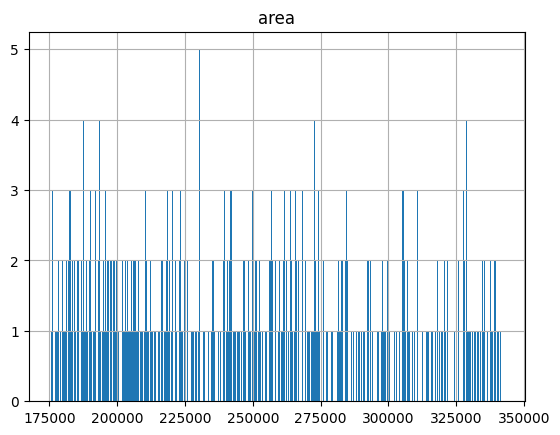

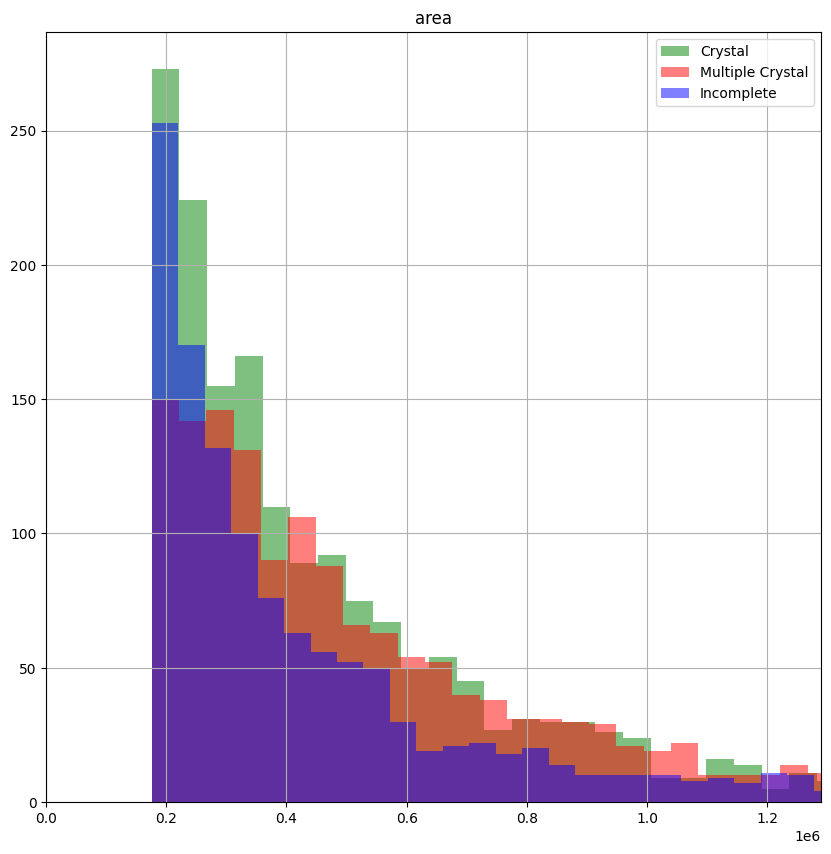

In [139]:
# Check: How much data is weird? Get an impression based on area
print(df_F4["area"].describe())
#df_F4[df_F4.area > 30*9.34**2].hist("area",bins=200)
df_F4[df_F4.area < 3.419470e+05].hist("area",bins=2000)

fig,ax = plt.subplots(figsize=(10,10))
c_list = ["g","r","b","k"]
for ii,label_oi in enumerate(df_F4.Labels.unique()):
    df_sub = df_F4[df_F4.Labels == label_oi]
    c_oi = c_list[ii]
    df_sub.hist(column="area",bins=2000,color=c_oi,alpha=.5,ax=ax,label=label_oi)
    print(label_oi)
    print(df_sub["area"].describe())
    print()
ax.legend()
ax.set_xlim(0,1.289736e+06)

In [140]:
def df_to_stacked_barplots(df:pd.DataFrame,independent_var:str,
                           ordering:list=None):

    row_list = []
    for var_oi in df[independent_var].unique():
        df_sub = df[df[independent_var] == var_oi]
        row = pd.concat([df_sub["Labels"].value_counts(),
                         pd.Series({independent_var:var_oi})])
        row_list.append(row)
    df_barplots = pd.DataFrame(row_list)

    # Unnormalized
    df_barplots = df_barplots.set_index(independent_var)
    if ordering:
        df_barplots = df_barplots.loc[ordering]
    df_barplots.plot(kind='bar',stacked=True,ylabel="Counts",title=f"Counts per Class: {independent_var}")

    # Normalized
    df_barplots_normalized = df_barplots.apply(lambda x: x/x.sum(),axis=1)
    df_barplots_normalized.plot(kind='bar',stacked=True,ylabel="Fraction", title=f"Fraction per Class: {independent_var}")
    plt.legend(loc="lower right")

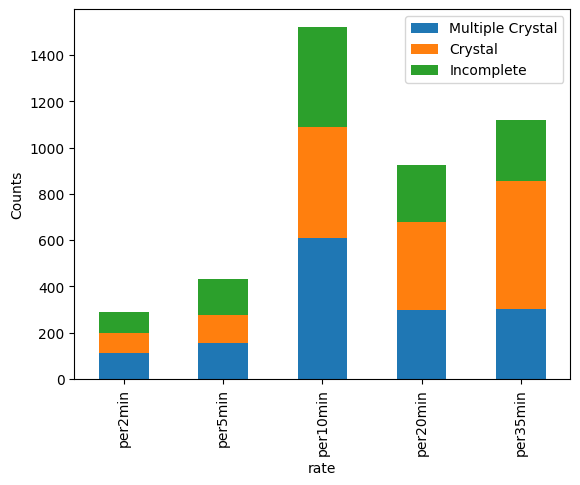

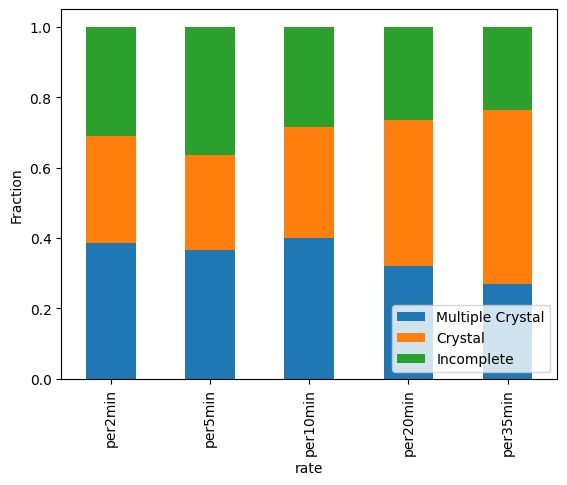

In [141]:
# Product Distribution bar plots for F4 (rates)

row_list = []
for rate in df_F4["rate"].unique():
    df_sub = df_F4[df_F4.rate == rate]
    row = pd.concat([df_sub["Labels"].value_counts(),pd.Series({"rate":rate})])
    row_list.append(row)
df_barplots = pd.DataFrame(row_list)

# Unnormalized
df_barplots = df_barplots.set_index("rate")
df_barplots = df_barplots.loc[["per2min","per5min","per10min","per20min","per35min"]]
df_barplots.plot(kind='bar',stacked=True,ylabel="Counts")

# Normalized
df_barplots_normalized = df_barplots.apply(lambda x: x/x.sum(),axis=1)
df_barplots_normalized.plot(kind='bar',stacked=True,ylabel="Fraction")
plt.legend(loc="lower right")

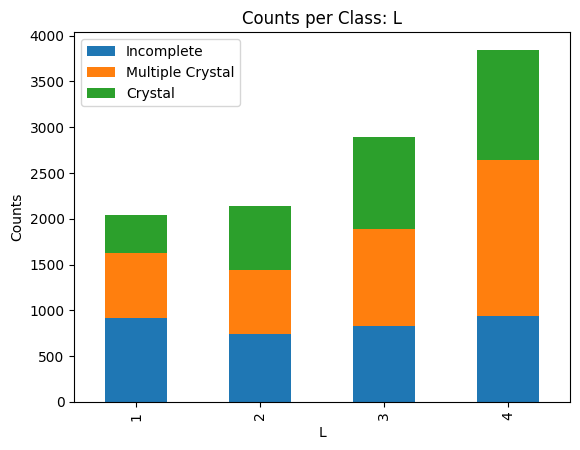

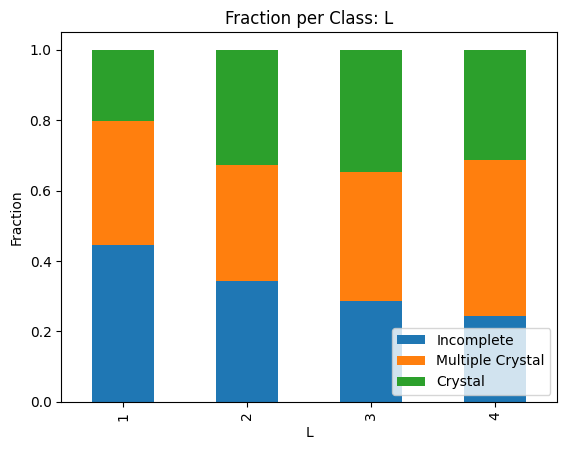

In [142]:
df_to_stacked_barplots(df_F34,"L")

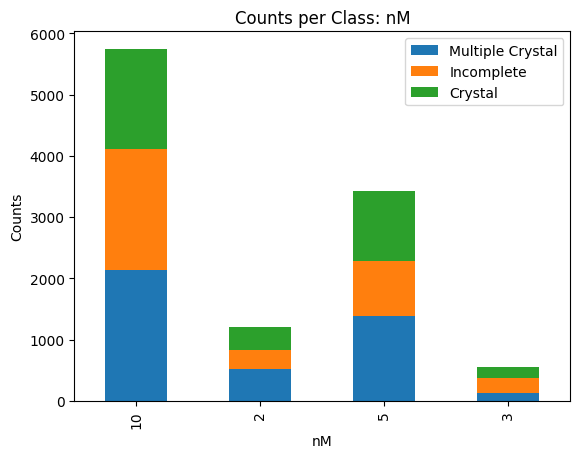

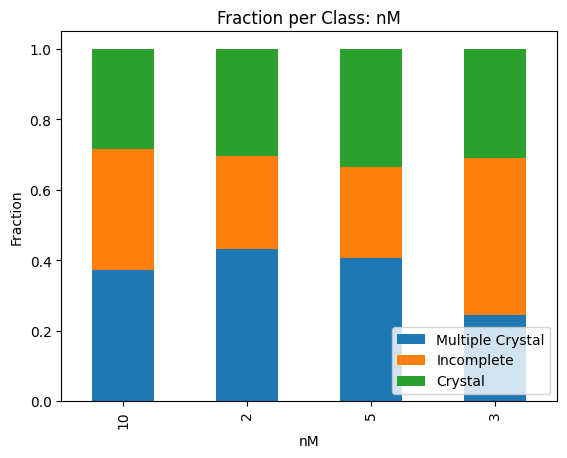

In [143]:
df_to_stacked_barplots(df_F34,"nM")